# Beam Shape Analysis - Tapered Fibre 2

### What does this notebook do?

Experimental analysis
- Import Gaussian beamshape data and z values through pandas to np arrays
- Translate and transform Gaussians to reduce fitting parameters 
- Fit the beamshape Gaussians to a one parameter fit to find their waists, w
- multiply z by sin(theta), where theta is the elevation angle of the setup - so that we resolve the projection onto the camera image
- Plot ws vs zsin(theta) and fit to (Two/ three parameter?) Fit
- Key: what is z0 and w0 experimentally for the fibre?

Theoretical Analysis
- Takes in wavelength, NA, core radius to calculate V number
- Use marcuse relation to find minumum waist
- Comparison?

## Import all useful libraries / tools

In [308]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.optimize import curve_fit
from os import listdir
import scipy

from lvl4_functions import *

## Import Data

In [309]:
# Define useful path to data
globalpath = "C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/1. Data Analysis/Christmas Report/Fibre2-30-11/Data/"

In [310]:
# Import data
distances, amplitudes = import_data(globalpath)

['101.csv', '102.csv', '103.csv', '104.csv', '105.csv', '106.csv', '107.csv', '108.csv', '109.csv', '110.csv', '111.csv', '112.csv', '113.csv', '114.csv', '115.csv', '116.csv', '117.csv', '118.csv', '119.csv', '120.csv', '121.csv', '122.csv', '123.csv', '124.csv']


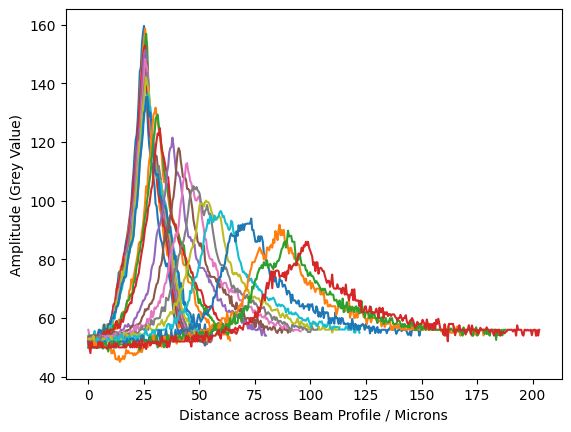

In [311]:
# Quick plot of raw data
for i in range(len(distances)):
    plt.plot(distances[i], amplitudes[i])

plt.xlabel('Distance across Beam Profile / Microns')
plt.ylabel('Amplitude (Grey Value)')

plt.show()

## Normalise, cut down data

In [312]:
all_distances, all_amps = data_trim(distances, amplitudes, 10000000)

## Errors - for above normalised Gaussians

In [313]:
''' Error on cross sectional distance'''
# Scale says ~2 pixels / microns therefore 0.5 microns / pixel
# so lets set error as 0.5 microns

all_distances_errors = []

for i in range(len(all_distances)):
    all_distances_errors.append(np.ones(np.size(all_distances[i]))*0.5) # takes into account different sized data sets

''' Error on amplitude '''
# Grey value resolution = 1

all_amps_errors = []

for i in range(len(all_amps)):
    err = 1 / np.max(amplitudes[i])
    all_amps_errors.append(np.ones(np.size(all_amps[i]))*err) # takes into account different sized data sets

Plot Normalised Gaussian Curves with Errors

Text(0, 0.5, 'Normalised Amplitude')

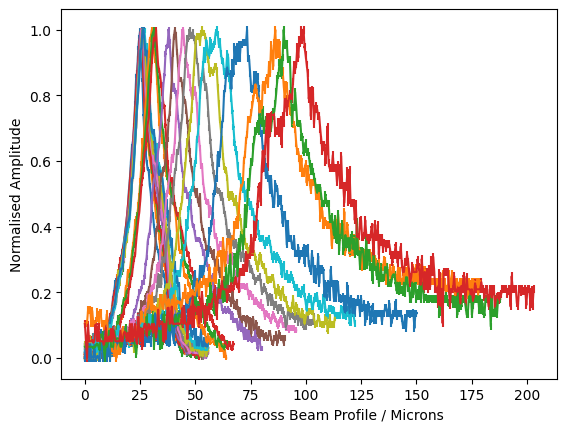

In [314]:
for i in range(len(all_distances)):
    plt.errorbar(all_distances[i], all_amps[i], xerr=all_distances_errors[i],yerr=all_amps_errors[i])

plt.xlabel('Distance across Beam Profile / Microns')
plt.ylabel('Normalised Amplitude')

<ErrorbarContainer object of 3 artists>

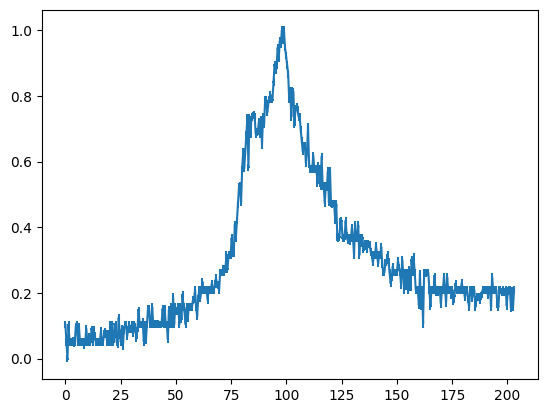

In [315]:
# Plot of a far field 'Gaussian' - is this a TEM10 mode?
largeind = -1
plt.errorbar(all_distances[largeind], all_amps[largeind], xerr=all_distances_errors[largeind],yerr=all_amps_errors[largeind])

## Fit Data

Text(0.5, 1.0, 'Waist Size Trend - Errorbars too small to see')

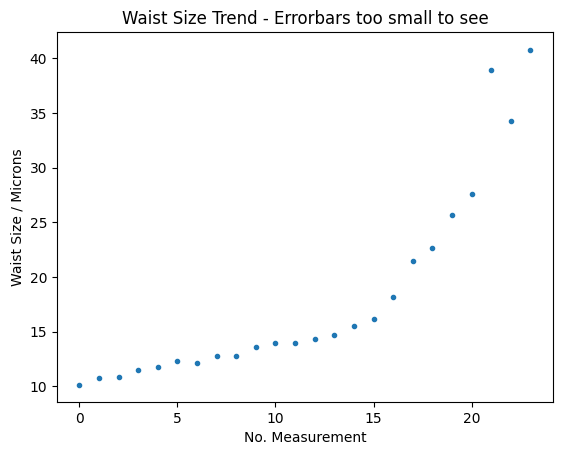

In [316]:
# Create some empty arrays to store values of interest
params_ = np.zeros((len(all_distances),2))
y_fits = [] # NB: this has to be a list due to different sized arrays sitting in it
params_errs_ = np.zeros((len(all_distances),2))
chi_red_array = np.zeros(len(all_distances))

# Populate initial guess array - important to change per data set!!
initial_guesses = np.zeros((len(all_distances),2))
initial_guesses[:,1] = 20
initial_guesses[:,0] = 3
initial_guesses[5,0] = 15
initial_guesses[6,0] = 15
initial_guesses[11:14,0] = 20
initial_guesses[14:,0] = 40
initial_guesses[14:,1] = 50
initial_guesses[21:1] = 1
initial_guesses[0,0] = 0.2

for i in range(len(all_distances)):
    singlefit, params_[i], params_errs_[i], chi_red_array[i] = fit_labs(all_distances[i],all_amps[i], all_amps_errors[i], Gauss, initial_guesses[i])
    y_fits.append(singlefit)

waists = params_[:,0]
waists_errs = params_errs_[:,0]

# Plot waist trend 
plt.errorbar(np.arange(len(distances)),waists, yerr = waists_errs, linestyle = '', marker = 'o', ms = 3)
plt.xlabel('No. Measurement')
plt.ylabel('Waist Size / Microns')
plt.title('Waist Size Trend - Errorbars too small to see')

#print(waists, waists_errs)

(-10.0, 10.0)

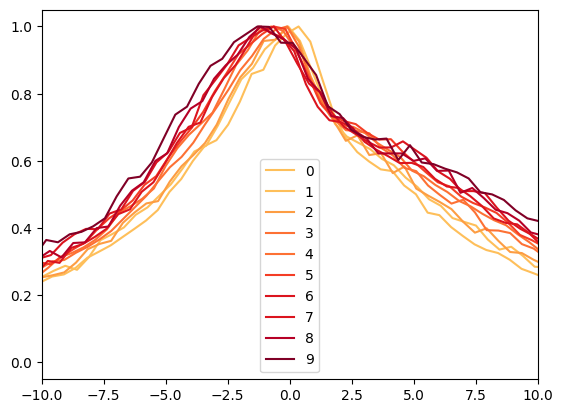

In [317]:
ab = 0
aa = 9
#plt.plot(all_distances[ab],all_amps[ab])

range_ = 10

colours = mpl.colormaps['YlOrRd'].resampled(range_)
colorsA = [colours(j) for j in np.linspace(0.3, 0.9, range_)]

for ab in range(range_):
    plt.plot(all_distances[ab]  - params_[ab,1],all_amps[ab], label = ab, color = colorsA[ab])
    plt.legend()

plt.xlim(-10,10)
#plt.plot(all_distances[aa],all_amps[aa])
#plt.plot(all_distances[aa] - params_[aa,1],y_fits[aa], label = aa)

## Calculating Z values and Plotting Waist size against Z

In [318]:
# Define Global Path for where 'z' values are stored
z_path = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/1. Data Analysis/Christmas Report/Fibre2-30-11/Data/zs.csv'

# Import as dataframe
df_lengths = pd.read_csv(z_path)

# Convert to array. Called 'lengths' as this isnt the z values yet
lengths = np.array(df_lengths['Length'])

# Take error as pixel width ie 0.5 microns (1sf)
lengths_errs = np.ones(len(lengths))*0.5

In [319]:
print(lengths)

[  0.      1.42    2.721   3.904   5.205   6.743   8.045  10.292  12.895
  16.443  20.465  26.261  34.069  44.952  54.415  62.617  72.869  84.073
  94.005 104.101 117.351 137.224 156.155 175.076]


## Fit Waists vs Z

In [320]:
# Need wavelength of light to calc. Rayleigh Range (in microns)
wavelength = 0.405
wavelength_err = 0.005 # according to online spec (THORLABS CPS405)

Angle of elevation

C:\Users\abiga\AppData\Local\Temp\ipykernel_15848\2489509289.py:21: RuntimeWarning: divide by zero encountered in divide
  zs_err = np.abs(zs*np.sqrt( (cos_err / np.cos(angle))**2 + (lengths_errs/lengths)**2 ))
C:\Users\abiga\AppData\Local\Temp\ipykernel_15848\2489509289.py:21: RuntimeWarning: invalid value encountered in multiply
  zs_err = np.abs(zs*np.sqrt( (cos_err / np.cos(angle))**2 + (lengths_errs/lengths)**2 ))


<ErrorbarContainer object of 3 artists>

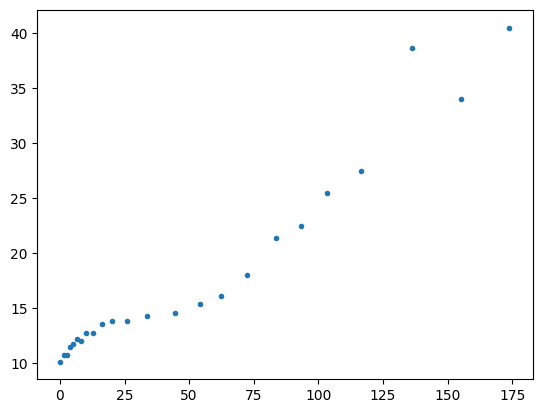

In [321]:
# online protractor at https://www.ginifab.com/feeds/angle_measurement/ 
# NB: see image 'C:\Users\abiga\OneDrive - Durham University\1. Fourth Year\1. Project\1. Data Analysis\Christmas Report\Cleaved-2\Cleaved - fibre- pics\cleaved_elev_angle'

angle_deg = 7
angle_deg_err = 1
angle = angle_deg * np.pi / 180
angle_err = angle_deg_err * np.pi / 180

''' Multiplying measured lengths and waists by cos theta
Why? as then we are looking at the horizontal projection onto the plane perpendicular to the direction that the camera points in'''

zs = lengths*np.cos(angle)
waists_comp = waists*np.cos(angle)

# Error due to cos of the angle
cos_err = np.abs(np.cos(angle + angle_err) - np.cos(angle))
# Error on new projected waists
waists_comp_err = waists_comp*np.sqrt( (cos_err / np.cos(angle))**2 + (waists_errs/waists)**2 )

# Error on zs
zs_err = np.abs(zs*np.sqrt( (cos_err / np.cos(angle))**2 + (lengths_errs/lengths)**2 ))
# 6th data point is div by zero so replace error with previous - they are all about the same
# zs_err[5] = zs_err[4]

# A plot to zoom in on the first few data points
plt.errorbar(zs, waists_comp, xerr = zs_err, yerr = waists_comp_err, linestyle = '', marker = 'o', ms = 3)


In [322]:
# Anomalous values??
anom_y = waists_comp[-3]
anom_x = zs[-3]

#fit without bottom bit??
waist_fit, params, params_errs, chisqu_WvsZ = fit_labs(zs[9:], waists_comp[9:], waists_comp_err[9:], WvsZ, np.array([5,1,2]))
w0, z0,RR= params
w0_err, z0_err,RR_err = params_errs

The minimum waist is 13.632478210883374 pm 0.018132091780212016
The distance from the first measurement to the minimum waist is 25.34019468541911 pm 0.23091750708814496
The Rayleigh Range is 51.382694533638585 pm 0.1498296506422454.
446.8775243943301


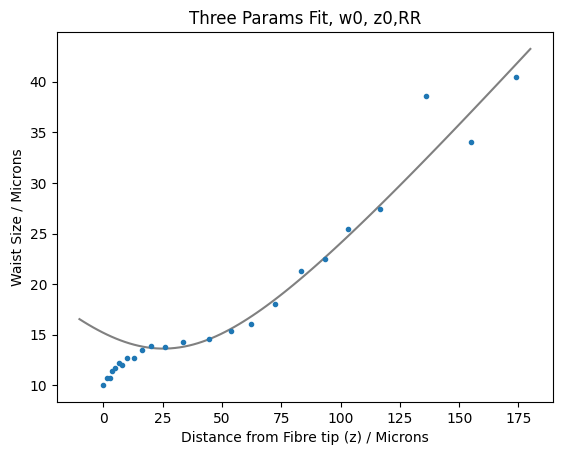

In [323]:
# Plot waists vs Z:
plt.errorbar(zs, waists_comp, yerr = waists_comp_err, linestyle = '', marker = 'o', ms = 3)
plt.plot(np.linspace(-10,180,100), WvsZ(np.linspace(-10,180,100), w0, z0,RR), color = 'grey')

plt.xlabel('Distance from Fibre tip (z) / Microns')
plt.ylabel('Waist Size / Microns')
plt.title('Three Params Fit, w0, z0,RR')

print('The minimum waist is {} pm {}'.format(w0, w0_err))
print('The distance from the first measurement to the minimum waist is {} pm {}'.format(z0, z0_err))
#print('The weird systematic error Y is {} pm {}'.format(Y0, Y0_err))
print('The Rayleigh Range is {} pm {}.'.format(RR,RR_err))
print(chisqu_WvsZ)

In [324]:
print('The wavelength check in nanometres is {} nm'.format(wavelength_check(w0,RR)))
print('This is approx. {}x the actual wavelength'.format( wavelength_check(w0,RR) / (wavelength*10**3)))

The wavelength check in nanometres is 11362.728295263918 nm
This is approx. 28.05611924756523x the actual wavelength


## Now Move Graph so waist min is at z = 0

In [325]:
# horizontal axis with min fitted waist set to zero
zs_0 = zs - z0
zs_0_err = np.sqrt(zs_err**2 + z0_err**2)

# z value at which fibre end occurs
z_end = zs_0[0] - 1

z_end_err = np.sqrt(zs_0_err[1]**2 + 0.5**2) # error on 4 measurement of 1 micron - high!

print('The fibre end is at z value {} pm {}'.format(z_end,z_end_err))
z_end = np.round_(z_end, decimals = 0)
z_end_err = np.round_(z_end_err, decimals = 0)

# Residuals 
wz_res = norm_residuals(zs,waists_comp,waists_comp_err,WvsZ,params)

The fibre end is at z value -26.34019468541911 pm 0.7413638278862484


[]

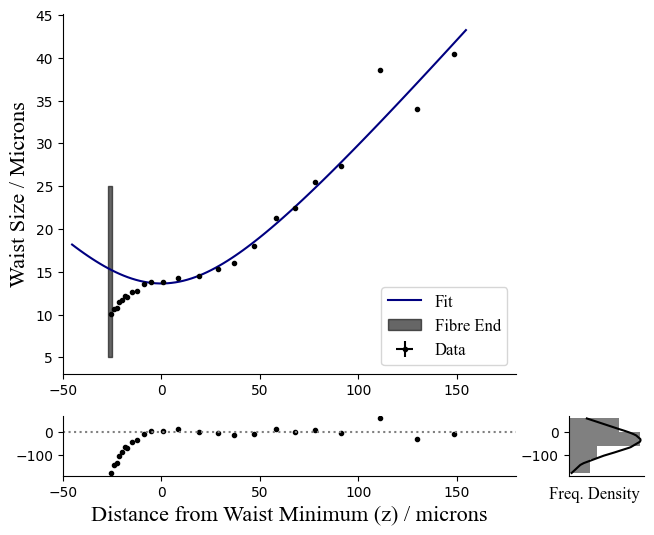

In [326]:
# Create Figure
fig, ((ax1,ax3),(ax2,ax4)) = plt.subplots(2,2,height_ratios=(6,1), width_ratios=(6,1), figsize = (7.5,6))

# Font Settings
font1 = mpl.font_manager.FontProperties(family='Times New Roman',
style='normal', size=12)

# Kill dead plots
ax3.axis('off')
# Kill spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# Plot waists vs Z:
ax1.errorbar(zs_0, waists_comp, xerr = zs_0_err, yerr = waists_comp_err, color = 'k', linestyle = '', marker = 'o', ms = 3, label = 'Data')
ax1.plot(np.linspace(-20,180,100) - z0, WvsZ(np.linspace(-20,180,100), w0, z0,RR), color = 'navy', label = 'Fit')

# Plot vertical fill line of where fibre end is
ax1.fill_betweenx(y=[5,25],x1=[z_end - z_end_err,z_end - z_end_err] , x2=[z_end + z_end_err,z_end + z_end_err], color = 'k', alpha = 0.6, label = 'Fibre End')

# #Plot anomaly
# ax1.errorbar(anom_x - z0, anom_y, color = 'k', label = 'Anomaly', marker = 'x', ms = 8, linestyle = '')

# Residuals
ax2.errorbar(zs_0,wz_res,color = 'k', linestyle = '', marker = 'o', ms = 3)
ax2.errorbar([-50,180], [0,0], color = 'grey', linestyle = 'dotted')

# Histogram
mean, stderr, sorted_res, dist = histogram_plot(wz_res)
ax4.plot(dist, sorted_res, color = 'black')
ax4.hist(sorted_res, density = True, orientation = 'horizontal', color = 'grey', bins = 4)

# Axis labels
ax2.set_xlabel('Distance from Waist Minimum (z) / microns', font = 'Times New Roman', fontsize = 16)
ax1.set_ylabel('Waist Size / Microns', font = 'Times New Roman', fontsize = 16)
ax1.legend(prop = font1, loc = 'lower right')
ax4.set_xlabel('Freq. Density      ', font = 'Times New Roman', fontsize = 12)

ax1.set_xlim(-50,180)
ax2.set_xlim(-50,180)

#Get Rid of Ticks
ax4.set_xticks(ticks = [], labels = [], fontfamily = 'Times New Roman', fontsize = 10)

# Make visible ticks times new roman
# ax1.set_xticks(ticks = np.arange(0,130,20), labels = np.arange(0,130,20), fontfamily = 'Times New Roman', fontsize = 11)
# ax2.set_xticks(ticks = np.arange(0,130,20), labels = np.arange(0,130,20), fontfamily = 'Times New Roman', fontsize = 11)

# ax1.set_yticks(ticks = np.arange(5,26,2.5), labels = np.round_(np.arange(5,26,2.5), decimals = 1), fontfamily = 'Times New Roman', fontsize = 11)
# ax2.set_yticks(ticks = np.arange(-5,6,5), labels = np.round_(np.arange(-5,6,5), decimals = 1), fontfamily = 'Times New Roman', fontsize = 11)
# ax4.set_yticks(ticks = np.arange(-5,6,5), labels = np.round_(np.arange(-5,6,5), decimals = 1), fontfamily = 'Times New Roman', fontsize = 11)

In [327]:
print('The minimum waist is {} pm {}'.format(w0, w0_err))
print('The distance from the first measurement to the minimum waist is {} pm {}'.format(z0, z0_err))
#print('The weird systematic error Y is {} pm {}'.format(Y0, Y0_err))
print('The Rayleigh Range is {} pm {}.'.format(RR,RR_err))

The minimum waist is 13.632478210883374 pm 0.018132091780212016
The distance from the first measurement to the minimum waist is 25.34019468541911 pm 0.23091750708814496
The Rayleigh Range is 51.382694533638585 pm 0.1498296506422454.


### A report figure - comparing TEM00 and TME10 Modes

In [328]:
ind = 1
ind2 = -1

first_z = zs_0[0]
last_z = zs_0[-1]
first_z_err = zs_err[0]
last_z_err = zs_err[-1]

# residuals
first_res = norm_residuals(all_distances[ind], all_amps[ind], all_amps_errors[ind], Gauss, params_[ind,:])
last_res = norm_residuals(all_distances[ind2], all_amps[ind2], all_amps_errors[ind2], Gauss, params_[ind2,:])

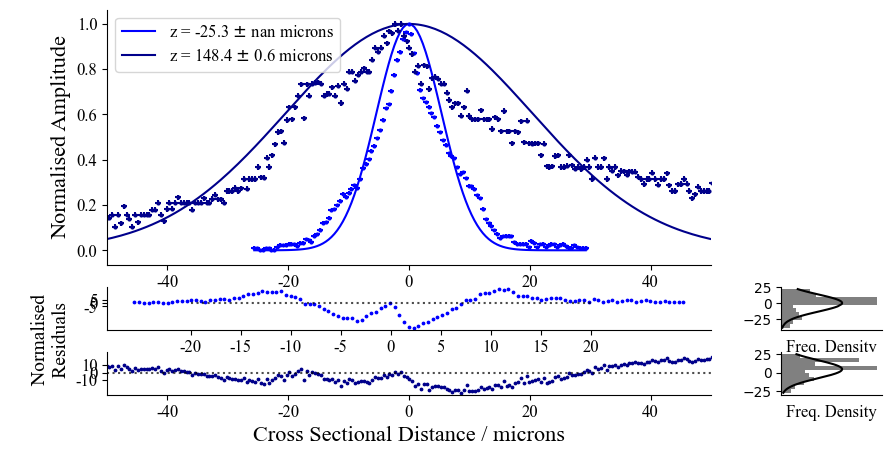

In [329]:
# Figure settings
fig1, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3,2, height_ratios=(6,1,1), width_ratios=(6,1), figsize = (10,5))
# Kill dead plots
ax4.axis('off')
# Kill spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)

# Font Settings
font = mpl.font_manager.FontProperties(family='Times New Roman',
style='normal', size=12)

# Main Plots
ax1.errorbar(all_distances[ind] - params_[ind,1],all_amps[ind], xerr=all_distances_errors[ind],yerr=all_amps_errors[ind], linestyle = '', marker = 'o', ms = 2, color = 'blue')
ax1.plot(all_distances[ind] - params_[ind,1], Gauss(all_distances[ind], *params_[ind,:]), color = 'blue', label = 'z = {} $\pm$ {} microns'.format(np.round_(first_z, decimals = 1), np.round_(first_z_err, decimals = 1)))
ax1.errorbar(all_distances[ind2] - params_[ind2,1],all_amps[ind2], xerr=all_distances_errors[ind2],yerr=all_amps_errors[ind2], linestyle = '', marker = 'o', ms = 2, color = 'darkblue')
ax1.plot(all_distances[ind2] - params_[ind2,1], Gauss(all_distances[ind2], *params_[ind2,:]), color = 'darkblue', label = 'z = {} $\pm$ {} microns'.format(np.round_(last_z, decimals = 1), np.round_(last_z_err, decimals = 1)))
ax3.set_xlabel('Cross Sectional Distance / microns', font = 'Times New Roman', fontsize = 16)
ax1.set_ylabel('Normalised Amplitude', font = 'Times New Roman', fontsize = 16)
ax1.legend(prop = font)

# Make x axes align
ax1.set_xlim(-50,50)
ax3.set_xlim(-50,50)

#Residuals
ax2.scatter(all_distances[ind] - params_[ind,1], first_res, s = 3, color = 'blue')
ax3.scatter(all_distances[ind2] - params_[ind2,1], last_res, s = 3, color = 'darkblue')
ax2.errorbar([-20,20], [0,0], color = 'black', alpha = 0.7, linestyle = 'dotted')
ax3.errorbar([-50,50], [0,0], color = 'black', alpha = 0.7, linestyle = 'dotted')
ax3.set_ylabel('\n               Normalised \n               Residuals ', font = 'Times New Roman', fontsize = 14)

# Histograms 
first_mean, first_stderr, first_sorted_res, first_dist = histogram_plot(first_res)
ax5.plot(first_dist, first_sorted_res, color = 'black')
ax5.hist(first_sorted_res, density = True, orientation = 'horizontal', color = 'grey')
last_mean, last_stderr, last_sorted_res, last_dist = histogram_plot(last_res)
ax6.plot(last_dist, last_sorted_res, color = 'black')
ax6.hist(last_sorted_res, density = True, orientation = 'horizontal', color = 'grey')
ax5.set_xlabel('Freq. Density', font = 'Times New Roman', fontsize = 12)
ax6.set_xlabel('Freq. Density', font = 'Times New Roman', fontsize = 12)


#Get Rid of Ticks
ax5.set_xticks(ticks = [], labels = [], fontfamily = 'Times New Roman', fontsize = 10)
ax6.set_xticks(ticks = [], labels = [], fontfamily = 'Times New Roman', fontsize = 10)

# Make visible ticks times new roman
ax1.set_xticks(ticks = [-40,-20,0,20,40], labels = [-40,-20,0,20,40], fontfamily = 'Times New Roman', fontsize = 12)
ax3.set_xticks(ticks = [-40,-20,0,20,40], labels = [-40,-20,0,20,40], fontfamily = 'Times New Roman', fontsize = 12)
ax2.set_xticks(ticks = np.arange(-20,24,5), labels = np.arange(-20,24,5), fontfamily = 'Times New Roman', fontsize = 12)

ax1.set_yticks(ticks = np.arange(0,1.2,0.2), labels = np.round_(np.arange(0,1.1,0.2), decimals = 1), fontfamily = 'Times New Roman', fontsize = 12)
ax2.set_yticks(ticks = np.arange(-5,6,5), labels = np.round_(np.arange(-5,6,5), decimals = 1), fontfamily = 'Times New Roman', fontsize = 12)
ax3.set_yticks(ticks = np.arange(-10,11,10), labels = np.round_(np.arange(-10,11,10), decimals = 1), fontfamily = 'Times New Roman', fontsize = 12)

In [330]:
print(zs_0)

[-25.34019469 -23.93077915 -22.63947661 -21.46529451 -20.17399197
 -18.64745598 -17.3551609  -15.12490969 -12.54131206  -9.01975831
  -5.02773769   0.7250598    8.47486015  19.27673992  28.66920416
  36.81006769  46.98565084  58.10613792  67.9641063   77.98485225
  91.13608876 110.86095843 129.65084962 148.43081536]


## Comparison to Experiment - Ray Optics Model

Find k0 and define constants 

In [331]:
# Defining Parameters of set-up
# info about fibre from 35m cable:
''' https://www.thorlabs.com/drawings/b4627de8c1f781cd-1251149A-D70E-815D-5BD8491D7FDA5B7B/PM1550-HP-SpecSheet.pdf '''

NA = 0.14 # numerical aperture 
NA_err = 0.01

k0 = find_k(wavelength)
k0_err = np.abs(find_k(wavelength+wavelength_err) - k0)
print(k0, k0_err)

a = 9.2e-6 / 2 # core radius, in metres 
a_err = 0.1e-6 / 2 

15514037.795505151 189195.5828720145


Find V_no and its error

In [332]:
V_no = V_number(NA, k0, a)

EC_NA = np.abs(V_number(NA+NA_err, k0, a) - V_no)
EC_k0 = np.abs(V_number(NA, k0+k0_err, a)- V_no)
EC_a = np.abs(V_number(NA, k0, a+a_err) - V_no)

V_no_err = np.sqrt(EC_NA**2 + EC_k0**2 + EC_a**2)

In [333]:
print('The predicted V no is {} pm {}'.format(V_no, V_no_err))

The predicted V no is 9.99104034030532 pm 0.7320719127024782


Using the Marcuse relation to compute theoretical minimum waist from V number and core radius

In [334]:
w0_theory = marcuse(V_no,a)

# error on w0
cont_V_no = np.abs(marcuse(V_no+V_no_err,a) - w0_theory)
cont_a = np.abs(marcuse(V_no,a+a_err) - w0_theory)

w0_theory_err = np.sqrt(cont_V_no**2 + cont_a**2)

In [335]:
print('The predicted minimum waist using the ray optics model is {} pm {} microns'.format(w0_theory,w0_theory_err))

The predicted minimum waist using the ray optics model is 3.2258376461429026 pm 0.042342748239619886 microns
